#Introduction


AI Introduction Workshop (Image Classification)


*   **Workshop duration:** 1.30h
*   **Prerequisite:** Notions in AI, Python & tensorFlow2.0. +An introduction to Transfer Learning on AI 101.

*   **Goal:** design a simple, yet efficient, model to solve any image classification problem. The workshop will illutrate how Transfer Learning works relying Tensorflow 2.0 and Keras.






# Import Libraries and Define functions

We leverage the work done in Part 1. You can use and update these functions as needed. 

In [ ]:
%tensorflow_version 2.x #to avoid loading another version at run time (since you can't change it after it's imported)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

###Functions

def normalize(train_images_, test_images_):
	# convert from integers to floats
	train_norm = train_images_.astype('float32')#convert numpy.float32: 32-bit-precision floating-point number type: sign bit, 8 bits exponent, 23 bits mantissa.
	test_norm = test_images_.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def conv_block(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None): 
  model_ = tf.keras.Sequential()
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  #maxPooling2D=output_shape = (input_shape - pool_size + 1) / strides)

  return model_

def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
def display_images(images_, labels_, rows_, cols_, additional_input_=''):#sample here is an image from a dataset tfds
  fig = plt.figure(figsize=(8,8))
  for img in range(rows_*cols_):
    ax = fig.add_subplot(rows_,cols_,1+img)
    ax.imshow(images_[img])
    ax.set_axis_off()
    if additional_input_!='':
      ax.set_title(str(labels_[img])+ ' vs: ' +str(additional_input_[img]))
    else:
      ax.set_title(str(labels_[img]))

def resize_image(image_, sizes=(32,32)):
  image = tf.image.resize_with_crop_or_pad(image_, sizes[0], sizes[1])
  return image


def crop_center_and_resize(img, size):
    s = tf.shape(img)
    w, h = s[0], s[1]
    c = tf.maximum(w, h)
    wn, hn = h / c, w / c
    result = tf.image.crop_and_resize(tf.expand_dims(img, 0),
                                      boxes=[[(1 - wn) / 2, (1 - hn) / 2, wn, hn]],
                                      box_indices=[0], crop_size=[size, size],
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.squeeze(result, 0)


def get_images_and_labels(datasetv1Adapter):
  import time
  start_time = time.time()
  dataset = tfds.as_numpy(datasetv1Adapter)
  dataset = np.array(list(datasetv1Adapter))

  images=np.array([example["image"] for example in dataset])
  labels=np.array([example["label"] for example in dataset])
  print("--- %s seconds ---" % (time.time() - start_time))
  
  #If you're using datasetv1Adapter as input
  #images = np.array([example['image'] for example in datasetv1Adapter])
  #labels =  np.array([np.array(example['label']) for example in datasetv1Adapter])
  return images, labels

### - End Functions 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x #to avoid loading another version at run time (since you can't change it after it's imported)`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Image **Classification**

## Loading & Looking at the data

### Dataset Description

Tensorflow comes with various datasets already ready to be used. You can leverage them to learn or teach Machine Learning. 




*   **Dataset** list can be found [here](https://www.tensorflow.org/datasets/catalog/overview). In Part 1 we saw how we can  play with data loaded through keras and load_data() function ; we'll explore the full set of data available in tensorflow now. 
*   **And an introduction** to TF datasets can be found [here](https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html).




This is also one of Keras's [datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) easy to access and play with via the load_data() function. 

### More Data - TensorFlow DataSets 

There are two ways to load a dataset from tensorflow. The way we did it via tdfs or via the load_data() function in Keras, e.g., 

*    *fashion_mnist = keras.datasets.fashion_mnist*
*    *(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()*

Or we can go through Tensorflow datasets. This is what we'll learn first befor going further. 



### Load Dataset

**For this subsection we'll:**
*   Load the dataset
*   Encode classes (from integers into one-hot vectors)
*   Normalize images (floats & values between [0-1])




In [ ]:
#### Import tensorflow_datasets and name it tfds as an alias
import tensorflow_datasets as tfds


In [ ]:
dataset, info= tfds.load('cifar10:3.*.*', with_info=True)#oxford_iiit_pet

In [ ]:
train, test = dataset['train'], dataset['test']

In [ ]:
#@title split into images and labels
train_images, train_labels = get_images_and_labels(train)
test_images, test_labels = get_images_and_labels(test)
train_images.shape

--- 15.270779132843018 seconds ---
--- 3.2181522846221924 seconds ---


(50000, 32, 32, 3)

In [ ]:
#@title Let's look at the size for some images
[img.shape for img in train_images[:5]]

[(32, 32, 3), (32, 32, 3), (32, 32, 3), (32, 32, 3), (32, 32, 3)]

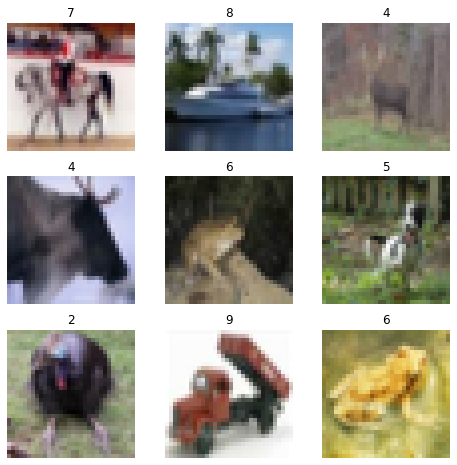

In [ ]:
#@title Display some images
display_images(train_images, train_labels, 3, 3)

In [ ]:
#@title Possibly resize-center-crop images
resize=False
if resize:
  import time
  start_time = time.time()
  train_images = np.array([np.array(resize_image(image)) for image in train_images]) # or crop_center_and_resise
  test_images = np.array([np.array(resize_image(image)) for image in test_images])
  print("--- %s seconds ---" % (time.time() - start_time))
test_images.shape

(10000, 32, 32, 3)

In [ ]:
#@title Let's look at the size for some images
[img.shape for img in train_images[:5]]

[(32, 32, 3), (32, 32, 3), (32, 32, 3), (32, 32, 3), (32, 32, 3)]

In [ ]:
#@title LoadData, Encode Labels and Normalize
#(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
if False: # (from integers into one-hot vectors)
  train_labels_encoded = tf.keras.utils.to_categorical(train_labels)
  test_labels_encoded = tf.keras.utils.to_categorical(test_labels)
  category_size=train_labels_encoded.shape[1]
else:
  train_labels_encoded = train_labels
  test_labels_encoded = test_labels
  category_size = len(set(train_labels_encoded))

train_images_norm, test_images_norm = normalize(train_images, test_images)
print(f'Phase 1/5: DataLoaded, Encoded And Normalized, there {category_size} categories')

input_shape=train_images[0].shape

'''#1-b optional - adapat input shape if you want your code to run for all datasets
if len(train_images.shape)==4: #no need to expand, just store input shape that we'll use for the CNN
  input_shape=train_images[0].shape
else: #expand both train and test image datasets
  train_images = np.expand_dims(train_images, axis=3) 
  test_images = np.expand_dims(test_images, axis=3)
  input_shape=train_images[0].shape
print('Phase 1/5 - optional: Input Shape Checked/Updated')'''

Phase 1/5: DataLoaded, Encoded And Normalized, there 10 categories


"#1-b optional - adapat input shape if you want your code to run for all datasets\nif len(train_images.shape)==4: #no need to expand, just store input shape that we'll use for the CNN\n  input_shape=train_images[0].shape\nelse: #expand both train and test image datasets\n  train_images = np.expand_dims(train_images, axis=3) \n  test_images = np.expand_dims(test_images, axis=3)\n  input_shape=train_images[0].shape\nprint('Phase 1/5 - optional: Input Shape Checked/Updated')"

In [ ]:
category_size

10

[texte du lien](https://)#Build and Train a Baseline Model

In [ ]:
#@title Create a basic model made of a convolutional bloc (e.g., at least one convolutional layer followed by a maxpooling layer)
def conv_block(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None): 
  model_ = tf.keras.Sequential()
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.2))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.3))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.4))
  return model_

In [ ]:
#SKIP THIS IF YOUR TESTING WITH CIFAR10 ONLY
#Training needs to have a 4 dimension shape. Which isn't the case for some datasets (e.g., Mnist). 
#Ex expand the shape of the dataset by one additional dimension when needed to make this code as generic as possible. 

'''expanded = False
if len(train_images.shape)==4: #no need to expand, just store input shape that we'll use for the CNN
  input_shape=train_images[0].shape
else: #expand both train and test image datasets
  train_images = np.expand_dims(train_images, axis=3) 
  test_images = np.expand_dims(test_images, axis=3)
  input_shape=train_images[0].shape
  expanded=True'''


"expanded = False\nif len(train_images.shape)==4: #no need to expand, just store input shape that we'll use for the CNN\n  input_shape=train_images[0].shape\nelse: #expand both train and test image datasets\n  train_images = np.expand_dims(train_images, axis=3) \n  test_images = np.expand_dims(test_images, axis=3)\n  input_shape=train_images[0].shape\n  expanded=True"

In [ ]:
#### Instanciate your model (if you build a function to create your model)
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)
#base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape=input_shape)
#base_model.trainable = False

In [ ]:
base_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
#@title create top layers and sequential model with base_model
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])# OK!

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 4, 4, 128)         435488    
_________________________________________________________________
sequential_6 (Sequential)    (None, 10)                1065834   
Total params: 1,501,322
Trainable params: 1,500,874
Non-trainable params: 448
_________________________________________________________________


In [ ]:
#@title  Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(train_labels_encoded.shape)

(50000,)


In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels_encoded = to_categorical(train_labels_encoded, 10)
test_labels_encoded = to_categorical(test_labels_encoded, 10)

In [ ]:
#@title Fit your model (you can use the test set as your validation data)
epochs = 100
augment_data=False

print(train_labels_encoded.shape)
print(test_labels_encoded.shape)
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

(50000, 10)
(10000, 10)
Training withOUT Augmented Data
Epoch 1/100
782/782 [==============================] - 7s 8ms/step - loss: 2.1566 - accuracy: 0.2171 - val_loss: 1.7891 - val_accuracy: 0.3646
Epoch 2/100
782/782 [==============================] - 6s 8ms/step - loss: 1.6012 - accuracy: 0.3997 - val_loss: 1.4533 - val_accuracy: 0.4635
Epoch 3/100
782/782 [==============================] - 6s 8ms/step - loss: 1.4339 - accuracy: 0.4695 - val_loss: 1.4502 - val_accuracy: 0.4829
Epoch 4/100
782/782 [==============================] - 6s 8ms/step - loss: 1.3134 - accuracy: 0.5183 - val_loss: 1.3198 - val_accuracy: 0.5330
Epoch 5/100
782/782 [==============================] - 6s 8ms/step - loss: 1.2278 - accuracy: 0.5514 - val_loss: 1.2076 - val_accuracy: 0.5674
Epoch 6/100
782/782 [==============================] - 6s 8ms/step - loss: 1.1594 - accuracy: 0.5812 - val_loss: 1.3070 - val_accuracy: 0.5419
Epoch 7/100
782/782 [==============================] - 6s 8ms/step - loss: 1.0996 - ac

In [ ]:
#@title  Evaluate your model via the evaluate function of a tf model
_, acc = model.evaluate(test_images, test_labels_encoded, verbose=1)
print('> %.3f' % (acc * 100.0))


313/313 [==============================] - 1s 3ms/step - loss: 0.5429 - accuracy: 0.8385
> 83.850


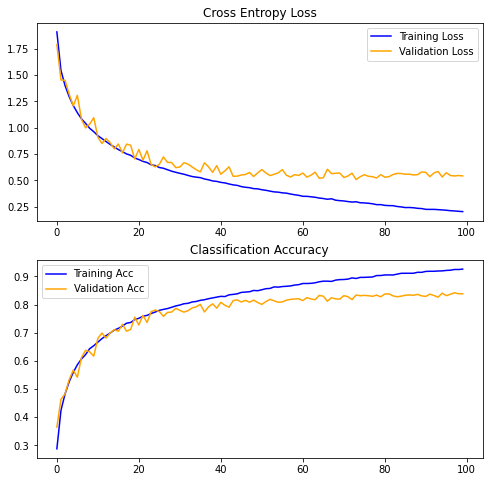

In [ ]:
#@title  Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

##With Data Augmentation

In [ ]:
# create the convNet
# create top layers and sequential model with base_model
# 
#@title create top layers and sequential model with base_model
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))
model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [ ]:
#@title with Data Augmentation
augment_data=True #OK
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [ ]:
#### Fit your model (you can use the test set as your validation data)
#@title  Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt2 = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100
print(test_labels_encoded.shape)
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))



(10000, 10)
Training with Augmented Data
Epoch 1/100
781/781 [==============================] - 30s 37ms/step - loss: 1.4563 - accuracy: 0.5035 - val_loss: 0.6737 - val_accuracy: 0.7748
Epoch 2/100
781/781 [==============================] - 29s 37ms/step - loss: 0.7473 - accuracy: 0.7424 - val_loss: 0.6785 - val_accuracy: 0.7765
Epoch 3/100
781/781 [==============================] - 29s 37ms/step - loss: 0.6917 - accuracy: 0.7606 - val_loss: 0.7061 - val_accuracy: 0.7744
Epoch 4/100
781/781 [==============================] - 29s 37ms/step - loss: 0.6496 - accuracy: 0.7780 - val_loss: 0.6605 - val_accuracy: 0.7725
Epoch 5/100
781/781 [==============================] - 29s 37ms/step - loss: 0.6222 - accuracy: 0.7869 - val_loss: 0.6830 - val_accuracy: 0.7804
Epoch 6/100
781/781 [==============================] - 29s 37ms/step - loss: 0.6056 - accuracy: 0.7911 - val_loss: 0.6482 - val_accuracy: 0.7846
Epoch 7/100
781/781 [==============================] - 29s 37ms/step - loss: 0.5801 - acc

KeyboardInterrupt: ignored

In [ ]:
# Evaluate your model via the evaluate function of a tf model
#@title  Evaluate your model via the evaluate function of a tf model
_, acc = model.evaluate(test_images, test_labels_encoded, verbose=1)
print('> %.3f' % (acc * 100.0))


313/313 [==============================] - 1s 3ms/step - loss: 0.5886 - accuracy: 0.8081
> 80.810


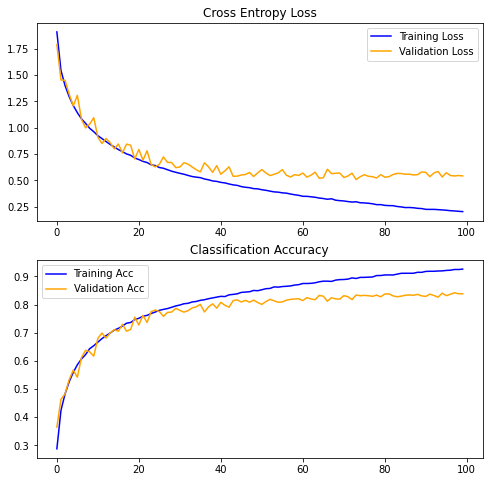

In [ ]:
accuracy_lost_curves(history)

# accuracy_loss_curves(history)

##With Transfer Learning

In [ ]:
#@title see tf.keras.applications.VGG19
base_model = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape=input_shape)
base_model.trainable = True #OK

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
#@title create top layers and sequential model with base_model
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))



In [ ]:
model= tf.keras.Sequential([
    base_model, 
    top_layers
])# OK!

In [ ]:
#### Fit your model (you can use the test set as your validation data)
#@title  Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt2 = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100
augment_data=False
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))



Training withOUT Augmented Data
Epoch 1/100
782/782 [==============================] - 25s 30ms/step - loss: 0.6362 - accuracy: 0.7825 - val_loss: 0.6182 - val_accuracy: 0.7895
Epoch 2/100
782/782 [==============================] - 24s 30ms/step - loss: 0.5030 - accuracy: 0.8299 - val_loss: 0.6391 - val_accuracy: 0.7942
Epoch 3/100
782/782 [==============================] - 23s 30ms/step - loss: 0.4133 - accuracy: 0.8589 - val_loss: 0.5241 - val_accuracy: 0.8253
Epoch 4/100
782/782 [==============================] - 23s 30ms/step - loss: 0.3320 - accuracy: 0.8866 - val_loss: 0.5332 - val_accuracy: 0.8348
Epoch 5/100
782/782 [==============================] - 23s 30ms/step - loss: 0.2706 - accuracy: 0.9060 - val_loss: 0.5542 - val_accuracy: 0.8325
Epoch 6/100
782/782 [==============================] - 23s 30ms/step - loss: 0.2136 - accuracy: 0.9256 - val_loss: 0.5631 - val_accuracy: 0.8363
Epoch 7/100
782/782 [==============================] - 23s 30ms/step - loss: 0.1709 - accuracy: 0.

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
sequential_10 (Sequential)   (None, 10)                279402    
Total params: 20,303,786
Trainable params: 20,303,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tf.keras.optimizers.SGD

In [ ]:
# data augmentation

In [ ]:
#### Fit your model (you can use the test set as your validation data)


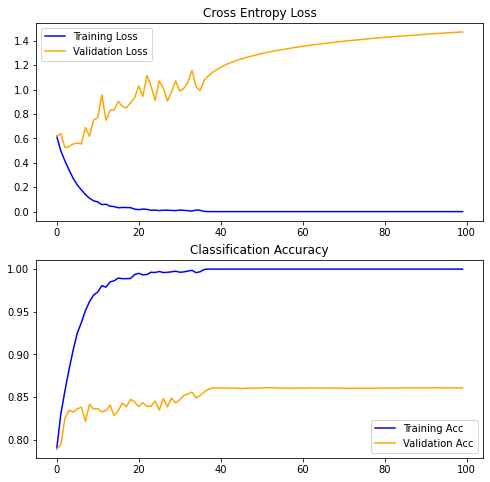

In [ ]:
accuracy_lost_curves(history)

## Transfer Learning v2 transfer learning and data augmentation

In [ ]:
# let's put it all in one
#### Fit your model (you can use the test set as your validation data)
#@title  Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt2 = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100validation_data
augment_data=True
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, =(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))



